In [51]:
import matplotlib.pyplot as plt
import numpy as np
from pyslfp import FingerPrint, plot, IceModel
from joblib import Parallel, delayed

from Part_III_Project import sea_surface_height_change as sshc

In [65]:
lmax = 128

resolution = 100  # number of points from -90 to 90 degrees

fields = 1000


In [ ]:
satellite_ranges = np.round(np.linspace(1, 90, resolution), 2)
fp = FingerPrint(lmax=lmax)
fp.set_state_from_ice_ng(version=IceModel.ICE7G, date=0.0)

X = fp.lebesgue_load_space()
mu = X.heat_kernel_gaussian_measure(0.1 * fp.mean_sea_floor_radius)


# Parallelize sample generation
def generate_sample(_):
    return mu.sample()


fields = Parallel(n_jobs=-1, verbose=2)(
    delayed(generate_sample)(i) for i in range(fields)
)
fields = np.array(fields)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 492 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 492 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 977 out of 1000 | elapsed:    6.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Done 977 out of 1000 | elapsed:    6.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    6.7s finished


Mean sea level change: 6.420228096576147e-12
Mean sea level change estimate: 6.3858553347205356e-12
Estimation error (%): 0.5353822533804122


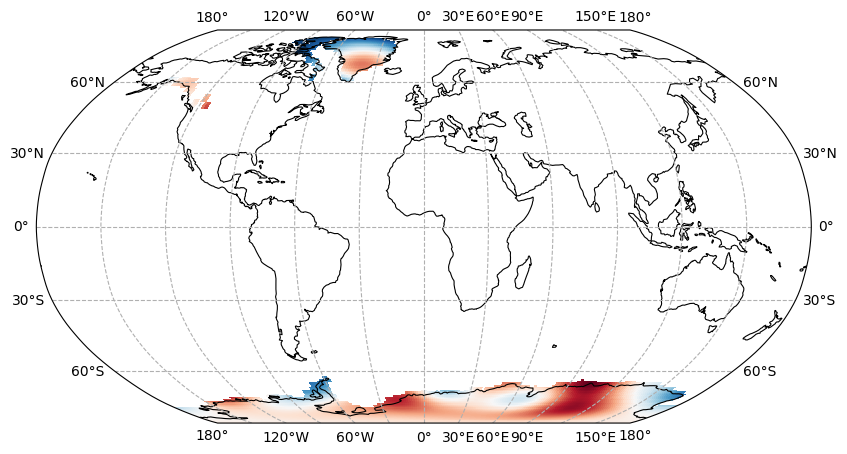

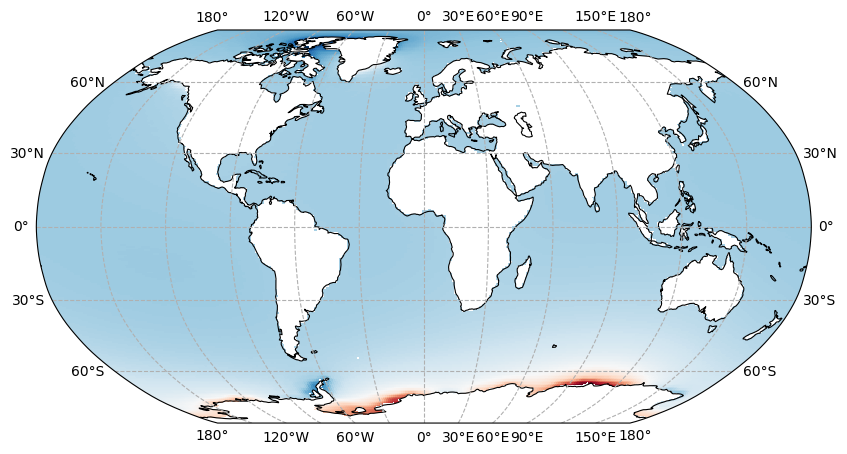

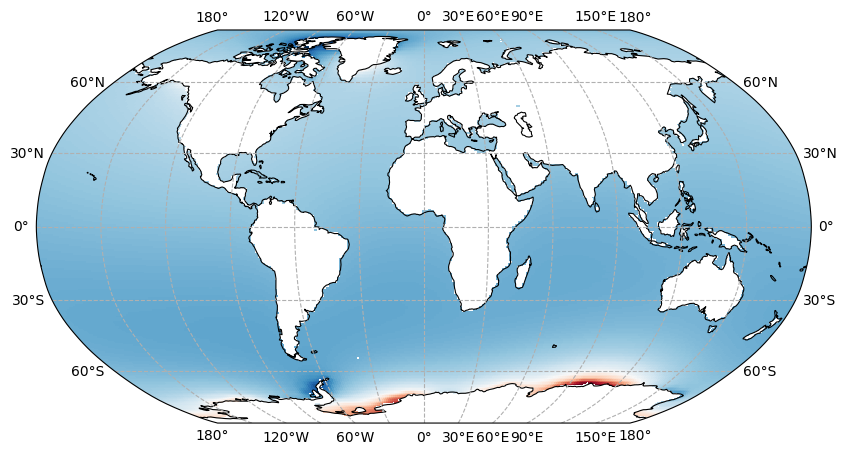

In [70]:
for field in fields[0:1]:
    direct_load = field * fp.ice_projection(value=0)

    fig1, ax1, im1 = plot(
        direct_load * fp.ice_projection(),
    )

    (
        sea_level_change,
        displacement,
        gravitational_potential_change,
        angular_velocity_change,
    ) = fp(direct_load=direct_load)

    fig2, ax2, im2 = plot(
        sea_level_change * fp.ocean_projection(),
    )

    sshchange = sshc(
        fp,
        sea_level_change,
        displacement,
        angular_velocity_change,
    )

    fig3, ax3, im3 = plot(
        sshchange * fp.ocean_projection(),
    )

    mean_sea_level_change = fp.mean_sea_level_change(direct_load)
    print("Mean sea level change:", mean_sea_level_change)

    altimetry_projection = fp.altimetry_projection(
        latitude_min=-66, latitude_max=66, value=0
    )
    altimetry_projection_integral = fp.integrate(altimetry_projection)
    altimetry_weighting_function = altimetry_projection / altimetry_projection_integral

    mean_sea_level_change_estimate = fp.integrate(
        altimetry_weighting_function * sshchange
    )

    error = (
        100
        * np.abs(mean_sea_level_change_estimate - mean_sea_level_change)
        / np.abs(mean_sea_level_change)
    )
    print("Mean sea level change estimate:", mean_sea_level_change_estimate)
    print("Estimation error (%):", error)

plt.show()

In [67]:
# using joblist and above logic, parrallelise over multiple samples over a range of satalite latitudes


def compute_altimetry_weighting_function(satellite_range):
    """Compute altimetry weighting function for a given satellite range."""
    altimetry_projection = fp.altimetry_projection(
        latitude_min=-satellite_range, latitude_max=satellite_range, value=0
    )
    altimetry_projection_integral = fp.integrate(altimetry_projection)
    altimetry_weighting_function = altimetry_projection / altimetry_projection_integral
    return altimetry_weighting_function


# Precompute altimetry weighting functions for all satellite ranges in parallel
altimetry_weighting_functions = Parallel(n_jobs=-1, verbose=10)(
    delayed(compute_altimetry_weighting_function)(satellite_range)
    for satellite_range in satellite_ranges
)


def compute_sshchange_and_mean_for_field(field):
    """Compute sea surface height change and mean sea level change for a given field."""
    direct_load = field * fp.ice_projection(value=0)

    (
        sea_level_change,
        displacement,
        gravitational_potential_change,
        angular_velocity_change,
    ) = fp(direct_load=direct_load)

    sshchange = sshc(
        fp,
        sea_level_change,
        displacement,
        angular_velocity_change,
    )

    mean_sea_level_change = fp.mean_sea_level_change(direct_load)

    return sshchange, mean_sea_level_change


def compute_error_for_satellite_range(
    sshchange, mean_sea_level_change, altimetry_weighting_function
):
    """Compute estimation error for a given satellite range."""
    mean_sea_level_change_estimate = fp.integrate(
        altimetry_weighting_function * sshchange
    )

    error = (
        100
        * np.abs(mean_sea_level_change_estimate - mean_sea_level_change)
        / np.abs(mean_sea_level_change)
    )
    return error


# First parallel run: compute SSH changes for all fields
sshchange_results = Parallel(n_jobs=-1, verbose=10)(
    delayed(compute_sshchange_and_mean_for_field)(field) for field in fields
)

# Second parallel run: compute errors for all combinations
errors = Parallel(n_jobs=-1, verbose=10)(
    delayed(compute_error_for_satellite_range)(sshchange, mean_slc, altimetry_wf)
    for sshchange, mean_slc in sshchange_results
    for altimetry_wf in altimetry_weighting_functions
)

errors = np.array(errors).reshape(len(fields), len(satellite_ranges))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.19490628265792267s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.038031816482543945s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  66 out of 100 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  88 out of 100 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | ela

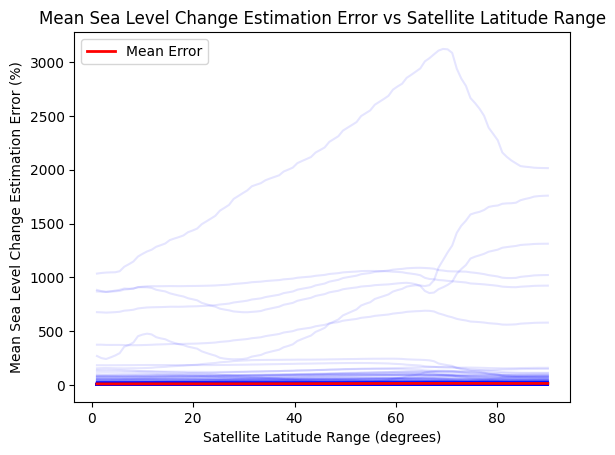

In [68]:
# plot errors across satellite ranges as lines for each field, with opacity = 0.1 and average across all fields as a bold line
plt.figure()
for i in range(errors.shape[0]):
    plt.plot(satellite_ranges, errors[i, :], color="blue", alpha=0.1)
plt.plot(
    satellite_ranges,
    np.mean(errors, axis=0),
    color="red",
    linewidth=2,
    label="Mean Error",
)
plt.xlabel("Satellite Latitude Range (degrees)")
plt.ylabel("Mean Sea Level Change Estimation Error (%)")
# log y axis
# plt.yscale("log")
plt.title("Mean Sea Level Change Estimation Error vs Satellite Latitude Range")
plt.legend()
plt.show()


In [71]:
# plot a histogram of the errors at satellite ranges at intervals of 10 degrees
plt.figure()
for satellite_range in range(10, 91, 10):
    index = np.where(satellite_ranges == satellite_range)[0][0]
    plt.hist(
        errors[:, index],
        bins=30,
        alpha=0.5,
        label=f"Range ±{satellite_range}°",
    )
plt.xlabel("Mean Sea Level Change Estimation Error (%)")
plt.ylabel("Frequency")
plt.title("Histogram of Mean Sea Level Change Estimation Errors")
plt.legend()
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 640x480 with 0 Axes>

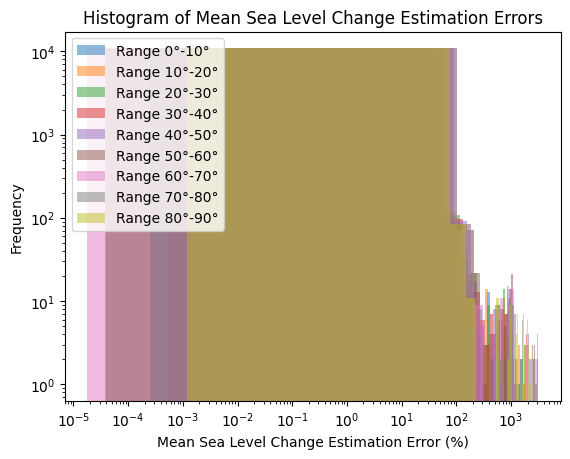

In [74]:
# plot a histogram of the errors at satellite ranges at intervals of range 10 degrees (0-10, 10-20, ..., 80-90), with a log x axis
plt.figure()
for i in range(9):
    range_min = i * 10
    range_max = (i + 1) * 10
    indices = np.where(
        (satellite_ranges >= range_min) & (satellite_ranges < range_max)
    )[0]
    if len(indices) == 0:
        continue
    combined_errors = errors[:, indices].flatten()
    plt.hist(
        combined_errors,
        bins=30,
        alpha=0.5,
        label=f"Range {range_min}°-{range_max}°",
    )
plt.xlabel("Mean Sea Level Change Estimation Error (%)")
plt.ylabel("Frequency")
plt.title("Histogram of Mean Sea Level Change Estimation Errors")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.show()

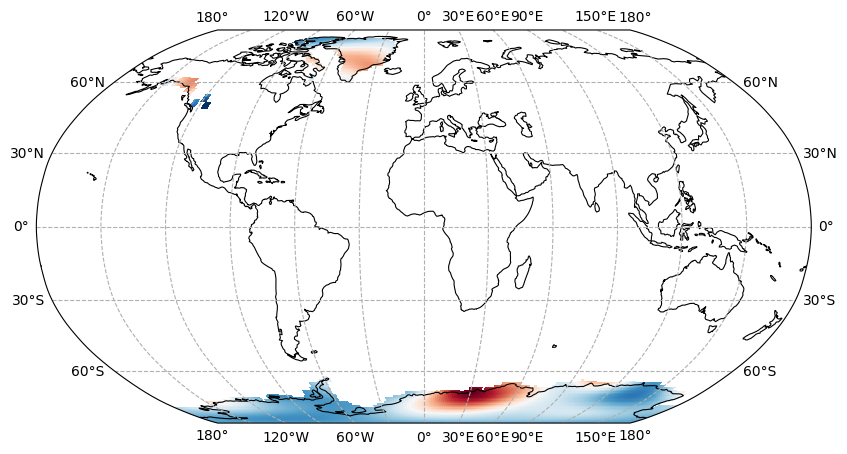

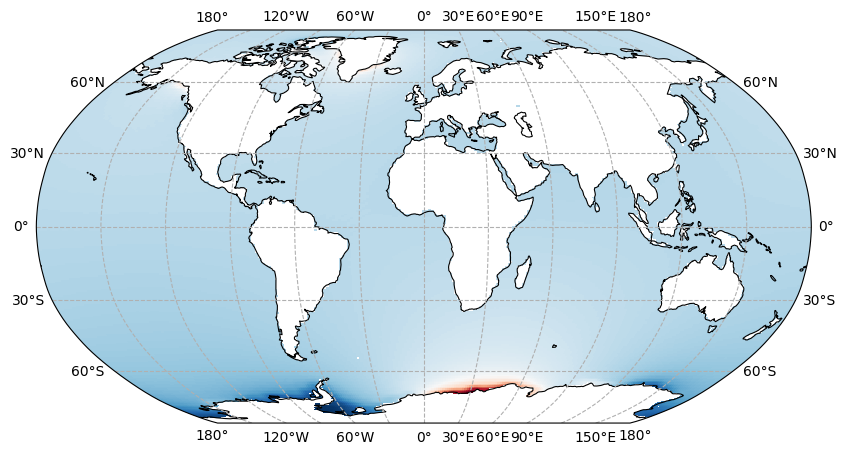

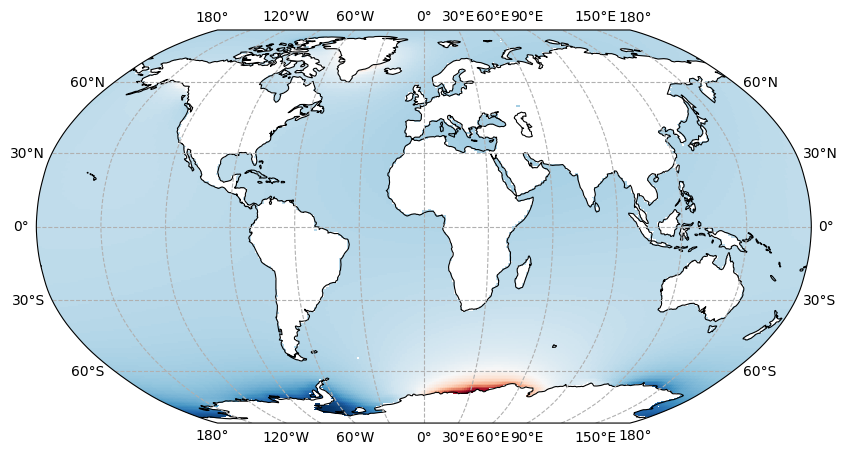

In [76]:
# plot the highest error field
max_error_index = np.unravel_index(np.argmax(errors, axis=None), errors.shape)
highest_error_field = fields[max_error_index[0]]
direct_load = highest_error_field * fp.ice_projection(value=0)
fig1, ax1, im1 = plot(
    direct_load * fp.ice_projection(),
)
(
    sea_level_change,
    displacement,
    gravitational_potential_change,
    angular_velocity_change,
) = fp(direct_load=direct_load)
sshchange = sshc(
    fp,
    sea_level_change,
    displacement,
    angular_velocity_change,
)
fig2, ax2, im2 = plot(
    sea_level_change * fp.ocean_projection(),
)
fig3, ax3, im3 = plot(
    sshchange * fp.ocean_projection(),
)
plt.show()